## VK Visual Insights 

С развитием социальных сетей начали происходитьт процессы перенасыщения и деградации:
- Люди подписаны на группу, но уже отписались от всех уведомлений и никак не учавствуют в ее жизни.
- Боты.
- Люди учавствуют в жизни сообщества, но при этом не имеют аккаунта в этой соц. сети и не подписаны
- Мероприятие разовое. Люди подписались/отписались или даже не подписывались.

Поэтому единственный доступный способ кроме анектирования - это анализ с помощью нейросетей фотографий с конкртеного мероприятия или нескольких.
- Показывает реальное кол-во вовлеченных в жизнь сообщества людей, которые являются 100% потенциальными клиентами.
- Показывает их возраст и гендерную принадлежность.

На момент написания данного приложения даже самые мощные онлайн нейросети делают анализ только 10-15 картинок (это их внутреннее ограничение). Что бы проанализировать сотни или тысячи фотографий необходима отдельное Аналитическое "приложение".

Анализ фото с мероприятий для изучения аудитории и рекомендаций продуктов/услуг.

Используя VK API, компьютерное зрение и аналитику, проект анализирует фото с мероприятий, выявляет демографический состав участников и предлагает персонализированные рекомендации на основе интересов сообщества.

In [1]:
from deepface import DeepFace
import os
import cv2

#Импортирт файлов из VK
import vk_api
import requests
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords


from PIL import Image
from io import BytesIO
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import shutil
import pickle


#Импортируем необходимые базовые библиотеки
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#Общие настройки вида таблиц
# Форматирование таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.width', 500)
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("darkgrid")

# создание константы RANDOM_STATE, TEST_SIZE
RANDOM_STATE = 210425
TEST_SIZE = 0.25



In [2]:
GROUPS = {
    "westra_tk": -403500  # Туристический клуб Вестра
}

ALBUM_IDS = {
    "westra_tk": [
        306954587,
        302408908,
        292582934,
        283784929
    ]
}

PHOTO_PATH = 'data/raw/'
OUTPUT_CSV = "dataset/analysis_results.csv"  # Файл для сохранения результатов
FACE_PATH =  "data/faces_raw"
EMBED_PATH = "data/face_embeddings.npy"

# Настройки
TOKEN = '618a8c5d618a8c5d618a8c5dc662baa2736618a618a8c5d0981bb4c8635c90c0f8a5ebd'  # Инструкция: https://dev.vk.com/api/access-token/getting-started

RESIZE_DIM = (1280, 1280)
DETECT_BACK = "retinaface"
MODEL_NAME = "VGG-Face"
MAX_PHOTOS = 50  # Лимит фотографий на сообщество
PREF_SIZES = [ "z", "y", "x", "m", "s"] #размеры фотографий, выбирается бОльшее из найденных 
FACE_SIZE = 50 #Минимально возможный размер куска фотографии с лицом, отфильтровать "мусор"
THRESHOLD = 0.50  # Порог схожести (чем меньше, тем строже)

In [3]:
#"""Проверка размытости через дисперсию лапласиана"""
def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold

In [4]:
def simple_preprocess_face(img, target_size=(224, 224)):
    """Минимальная предобработка лица для подачи в модель DeepFace."""
    # Переводим в RGB, если изображение в BGR
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Масштабируем под нужный размер модели
    img = cv2.resize(img, target_size)
    
    # Нормализация в диапазон [0, 1]
    img = img.astype(np.float32) / 255.0
    
    # Добавляем батч размерности
    img = np.expand_dims(img, axis=0)
    
    return img

In [5]:
#Функция для построения графиков распределения в каждом из признаков .
def hist_graph(df, list_pl, list_pl_name, suptitle='', p_hue=None):
    max_row = 1
    #Фигура для графиков и заголовке 
    plt.figure(figsize=[15,2])
    plt.suptitle (suptitle , ha='center', fontsize='25')
    plt.subplots_adjust(top=0.93, hspace=0.3)
    
    for i,param, name in zip(range(0,len(list_pl)),list_param, list_name_param):
        plt.subplot(max_row,2,i+1)
        #График распределения всех параметров по категориям
        fig = sns.histplot(data=df, x=param, hue=p_hue, bins = 10) 
        plt.xlabel('Значение', fontsize="10")
        plt.ylabel('Частота', fontsize="10")
        plt.title(name, fontsize="15")
    plt.show()

## Собираем информацио о фотографиях

### Парсинг фотографий из VK

In [8]:
def resolve_group_id(vk, group_identifier):
    """Конвертирует screen_name в ID или возвращает числовой ID"""
    if isinstance(group_identifier, int):
        return group_identifier
    try:
        result = vk.method("utils.resolveScreenName", {"screen_name": group_identifier})
        if result and result["type"] == "group":
            return -result["object_id"]
        raise ValueError(f"Группа {group_identifier} не найдена")
    except Exception as e:
        print(f"Ошибка при получении ID: {e}")
        return None


def download_photos():
    vk = vk_api.VkApi(token=TOKEN)

    for group_name, group_id in GROUPS.items():
        resolved_id = resolve_group_id(vk, group_id)
        if not resolved_id:
            continue

        album_ids = ALBUM_IDS.get(group_name)
        if not album_ids:
            print(f"Пропущена группа {group_name}: album_ids не заданы.")
            continue

        # Получаем информацию об альбомах
        try:
            albums = vk.method("photos.getAlbums", {
                "owner_id": resolved_id,
                "need_system": 1
            })
        except Exception as e:
            print(f"❌ Не удалось получить альбомы группы {group_name}: {e}")
            continue

        # Сопоставляем album_id -> year
        album_years = {}
        for album in albums.get("items", []):
            if album["id"] in album_ids:
                dt = datetime.fromtimestamp(album["created"])
                album_years[album["id"]] = str(dt.year)

        for album_id in album_ids:
            year = album_years.get(album_id, str(album_id))
            save_dir = os.path.join(PHOTO_PATH, year)

            # Удаляем и создаём папку заново
            if os.path.exists(save_dir):
                shutil.rmtree(save_dir)
            os.makedirs(save_dir, exist_ok=True)

            print(f"\n📥 Загрузка фотографий: группа {group_name}, альбом {album_id}, папка {year}")

            downloaded = 0

            try:
                photos = vk.method("photos.get", {
                    "owner_id": resolved_id,
                    "album_id": album_id,
                    "extended": 0,
                    "count": 1000
                })

                sorted_photos = sorted(photos.get("items", []), key=lambda x: x["date"], reverse=True)

                for photo in tqdm(sorted_photos, desc=f"{group_name}_{year}"):
                    if downloaded >= MAX_PHOTOS:
                        break
                    try:
                        url = None
                        for ptype in PREF_SIZES:
                            url = next((size["url"] for size in photo["sizes"] if size["type"] == ptype), None)
                            if url:
                                break
                        if not url and "sizes" in photo:
                            url = photo["sizes"][0]["url"]

                        response = requests.get(url, timeout=10)
                        img = Image.open(BytesIO(response.content))
                        filename = f"{group_name}_{year}_{downloaded + 1:04d}.jpg"
                        img.save(os.path.join(save_dir, filename))
                        downloaded += 1
                    except Exception as e:
                        print(f" ⚠️ Ошибка загрузки фото: {e}")

            except Exception as e:
                print(f"❌ Ошибка загрузки альбома {album_id} для группы {group_name}: {e}")

            print(f"✅ Загружено {downloaded} фото в {save_dir}")


# Запуск
if __name__ == "__main__":
    download_photos()



📥 Загрузка фотографий: группа westra_tk, альбом 306954587, папка 2025


westra_tk_2025:   5%|███▏                                                            | 50/1000 [00:12<04:00,  3.94it/s]


✅ Загружено 50 фото в data/raw/2025

📥 Загрузка фотографий: группа westra_tk, альбом 302408908, папка 2024


westra_tk_2024:   5%|███▏                                                            | 50/1000 [00:11<03:29,  4.52it/s]


✅ Загружено 50 фото в data/raw/2024

📥 Загрузка фотографий: группа westra_tk, альбом 292582934, папка 2023


westra_tk_2023:   9%|██████                                                           | 50/532 [00:13<02:13,  3.61it/s]


✅ Загружено 50 фото в data/raw/2023

📥 Загрузка фотографий: группа westra_tk, альбом 283784929, папка 2022


westra_tk_2022:   9%|█████▊                                                           | 50/555 [00:11<01:54,  4.41it/s]

✅ Загружено 50 фото в data/raw/2022


### Поиск лиц

### Уникальные лица (+фильтр)

In [10]:
def filter_and_save_unique_faces(year_folder):
    input_pkl = os.path.join(FACE_PATH, f"{year_folder}_embeddings_info.pkl")
    output_dir = os.path.join("data/faces_unique", year_folder)
    os.makedirs(output_dir, exist_ok=True)

    print(f"\n📂 Уникализация: {year_folder}")

    try:
        with open(input_pkl, "rb") as f:
            embeddings_info = pickle.load(f)
    except FileNotFoundError:
        print(f"⛔ Пропущено: не найден {input_pkl}")
        return 0, 0

    embeddings_array = np.array([item[0] for item in embeddings_info])

    unique_indices = []
    used = set()

    for i in tqdm(range(len(embeddings_array)), desc=f" Уникальные лица: {year_folder}"):
        if i in used:
            continue
        unique_indices.append(i)
        for j in range(i + 1, len(embeddings_array)):
            if j in used:
                continue
            distance = 1 - cosine_similarity([embeddings_array[i]], [embeddings_array[j]])[0][0]
            if distance < THRESHOLD:
                used.add(j)

    for new_idx, original_idx in enumerate(unique_indices):
        _, face_img, source_img_name = embeddings_info[original_idx]
        filename = f"{year_folder}_unique_{new_idx:05d}.jpg"
        cv2.imwrite(os.path.join(output_dir, filename), cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR))

    print(f"✅ Уникальных лиц сохранено: {len(unique_indices)} из {len(embeddings_info)}")
    return len(unique_indices), len(embeddings_info)

# 🔁 Перебираем все .pkl файлы в FACE_PATH
summary = []
for file in sorted(os.listdir(FACE_PATH)):
    if file.endswith("_embeddings_info.pkl"):
        year = file.replace("_embeddings_info.pkl", "")
        unique_count, total_count = filter_and_save_unique_faces(year)
        summary.append((year, unique_count, total_count))

# 📊 Общая статистика
print("\n📊 Итоговая сводка:")
for year, unique_count, total_count in summary:
    if total_count > 0:
        print(f"{year:8} — Уникальные: {unique_count:3d} / Всего: {total_count:3d} ({unique_count/total_count:.2%})")
    else:
        print(f"{year:8} — нет данных")


📂 Уникализация: 2022


 Уникальные лица: 2022: 100%|█████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 157.00it/s]


✅ Уникальных лиц сохранено: 38 из 63

📂 Уникализация: 2023


 Уникальные лица: 2023: 100%|█████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 101.55it/s]


✅ Уникальных лиц сохранено: 52 из 65

📂 Уникализация: 2024


 Уникальные лица: 2024: 100%|███████████████████████████████████████████████████████| 136/136 [00:01<00:00, 125.54it/s]


✅ Уникальных лиц сохранено: 65 из 136

📂 Уникализация: 2025


 Уникальные лица: 2025: 100%|█████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 527.09it/s]

✅ Уникальных лиц сохранено: 17 из 43

📊 Итоговая сводка:
2022     — Уникальные:  38 / Всего:  63 (60.32%)
2023     — Уникальные:  52 / Всего:  65 (80.00%)
2024     — Уникальные:  65 / Всего: 136 (47.79%)
2025     — Уникальные:  17 / Всего:  43 (39.53%)


In [22]:
def analyze_and_save_demographics(group_name, embeddings_info, unique_indices):
    output_folder = os.path.join(UNIQUE_PATH, group_name)
    os.makedirs(output_folder, exist_ok=True)

    columns = [
        "filename", "face_number", "gender", "gender_score",
        "emotion", "emotion_score", "age", "analysis_time", "group"
    ]
    group_df = pd.DataFrame(columns=columns)
    face_counter = 0

    print(f"\n📊 Анализ лиц в группе: {group_name}")

    for idx in tqdm(unique_indices, desc=f"💾 {group_name} — анализ лиц"):
        embedding, face_img_save, source_img_name = embeddings_info[idx]

        face_filename = f"{group_name}_face_{face_counter:05d}.jpg"
        face_save_path = os.path.join(output_folder, face_filename)
        cv2.imwrite(face_save_path, cv2.cvtColor(face_img_save, cv2.COLOR_RGB2BGR))

        try:
            analysis_results = DeepFace.analyze(
                img_path=face_save_path,
                actions=["age", "gender", "emotion"],
                detector_backend="skip",
                enforce_detection=False,
                align=False,
                silent=True
            )

            face = analysis_results[0] if isinstance(analysis_results, list) else analysis_results
            gender = "Man" if face["gender"]["Woman"] < face["gender"]["Man"] else "Woman"
            gender_score = face["gender"][gender]
            emotion = max(face["emotion"], key=face["emotion"].get)
            emotion_score = face["emotion"][emotion]

            new_row = {
                "filename": face_filename,
                "face_number": face_counter + 1,
                "gender": gender,
                "gender_score": gender_score,
                "emotion": emotion,
                "emotion_score": emotion_score,
                "age": face["age"],
                "analysis_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "group": group_name
            }
            group_df = pd.concat([group_df, pd.DataFrame([new_row])], ignore_index=True)

        except Exception as e:
            print(f"  ⚠️ Ошибка при анализе {face_filename}: {e}")

        face_counter += 1

    print(f"✅ Сохранено: {face_counter} уникальных лиц из {group_name}")
    return group_df


# 🔁 Объединённая таблица
all_results_df = pd.DataFrame()

# 🔍 Перебираем все *_embeddings_info.pkl
for file in sorted(os.listdir(FACE_PATH)):
    if not file.endswith("_embeddings_info.pkl"):
        continue

    group_name = file.replace("_embeddings_info.pkl", "")
    embeddings_path = os.path.join(FACE_PATH, file)

    try:
        with open(embeddings_path, "rb") as f:
            embeddings_info = pickle.load(f)
    except:
        print(f"⛔ Пропуск {group_name}: не удалось загрузить {file}")
        continue

    embeddings_array = np.array([item[0] for item in embeddings_info])

    # Уникализация
    unique_indices = []
    used = set()
    for i in range(len(embeddings_array)):
        if i in used:
            continue
        unique_indices.append(i)
        for j in range(i + 1, len(embeddings_array)):
            if j in used:
                continue
            distance = 1 - cosine_similarity([embeddings_array[i]], [embeddings_array[j]])[0][0]
            if distance < THRESHOLD:
                used.add(j)

    group_df = analyze_and_save_demographics(group_name, embeddings_info, unique_indices)
    all_results_df = pd.concat([all_results_df, group_df], ignore_index=True)

# 💾 Сохраняем общий результат
all_results_df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
print(f"\n📁 Финальный CSV сохранён в {OUTPUT_CSV}")


📊 Анализ лиц в группе: westra_tk


💾 westra_tk — анализ лиц: 100%|███████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.50it/s]


✅ Сохранено: 16 уникальных лиц из westra_tk

📊 Анализ лиц в группе: runcomrun


💾 runcomrun — анализ лиц: 100%|███████████████████████████████████████████████████████| 80/80 [00:33<00:00,  2.40it/s]


✅ Сохранено: 80 уникальных лиц из runcomrun

📊 Анализ лиц в группе: geekpicnic


💾 geekpicnic — анализ лиц: 100%|██████████████████████████████████████████████████████| 43/43 [00:17<00:00,  2.49it/s]

✅ Сохранено: 43 уникальных лиц из geekpicnic

📁 Финальный CSV сохранён в dataset/analysis_results.csv


### Первичный анализ по лицам

In [23]:
#Основные данные об электродах;
df_face = pd.read_csv(OUTPUT_CSV, sep=',', decimal='.')
df_face 

,filename,face_number,gender,gender_score,emotion,emotion_score,age,analysis_time,group
0,westra_tk_face_00000.jpg,1,Man,99.67,sad,81.86,42,2025-05-02 18:40:02,westra_tk
1,westra_tk_face_00001.jpg,2,Man,59.31,neutral,99.16,32,2025-05-02 18:40:02,westra_tk
2,westra_tk_face_00002.jpg,3,Man,98.87,sad,75.17,34,2025-05-02 18:40:03,westra_tk
3,westra_tk_face_00003.jpg,4,Man,99.24,angry,100.00,45,2025-05-02 18:40:03,westra_tk
4,westra_tk_face_00004.jpg,5,Man,96.05,fear,90.51,36,2025-05-02 18:40:04,westra_tk
...,...,...,...,...,...,...,...,...,...
134,geekpicnic_face_00038.jpg,39,Man,99.96,sad,63.81,22,2025-05-02 18:40:58,geekpicnic
135,geekpicnic_face_00039.jpg,40,Man,99.91,sad,58.09,20,2025-05-02 18:40:59,geekpicnic
136,geekpicnic_face_00040.jpg,41,Man,99.30,sad,87.71,24,2025-05-02 18:40:59,geekpicnic
137,geekpicnic_face_00041.jpg,42,Man,99.91,happy,98.41,22,2025-05-02 18:41:00,geekpicnic


In [24]:
bins = [0, 18, 30, 45, 60, 100]
labels = ['<18', '18–29', '30–44', '45–59', '60+']
df_face['age_group'] = pd.cut(df_face['age'], bins=bins, labels=labels, right=False)

# 2. Общее распределение гендера и эмоций (в %)
gender_dist = df_face['gender'].value_counts(normalize=True) * 100
emotion_dist = df_face['emotion'].value_counts(normalize=True) * 100

# 3. Распределение по возрастным группам (в %)
age_group_dist = df_face['age_group'].value_counts(normalize=True) * 100

# 4. Гендер по возрастным группам (каждый возраст – 100%)
gender_by_age = pd.crosstab(df_face['age_group'], df_face['gender'], normalize='index') * 100

# 5. Эмоции по возрастным группам
emotion_by_age = pd.crosstab(df_face['age_group'], df_face['emotion'], normalize='index') * 100

# 6. Выводим результаты
print("=== Общее распределение по гендеру (%) ===")
print(gender_dist.round(2), '\n')

print("=== Общее распределение по эмоциям (%) ===")
print(emotion_dist.round(2), '\n')

print("=== Распределение по возрастным группам (%) ===")
print(age_group_dist.sort_index().round(2), '\n')

print("=== Гендер по возрастным группам (%) ===")
print(gender_by_age.round(2), '\n')

print("=== Эмоции по возрастным группам (%) ===")
print(emotion_by_age.round(2))

=== Общее распределение по гендеру (%) ===
gender
Man     67.63
Woman   32.37
Name: proportion, dtype: float64 

=== Общее распределение по эмоциям (%) ===
emotion
happy      28.78
sad        23.02
neutral    19.42
angry      15.11
fear       12.23
surprise    0.72
disgust     0.72
Name: proportion, dtype: float64 

=== Распределение по возрастным группам (%) ===
age_group
<18      0.00
18–29   37.41
30–44   57.55
45–59    5.04
60+      0.00
Name: proportion, dtype: float64 

=== Гендер по возрастным группам (%) ===
gender      Man  Woman
age_group             
18–29     61.54  38.46
30–44     71.25  28.75
45–59     71.43  28.57 

=== Эмоции по возрастным группам (%) ===
emotion    angry  disgust  fear  happy  neutral   sad  surprise
age_group                                                      
18–29       9.62     1.92  9.62  32.69    13.46 32.69      0.00
30–44      16.25     0.00 13.75  27.50    23.75 17.50      1.25
45–59      42.86     0.00 14.29  14.29    14.29 14.29      0.00


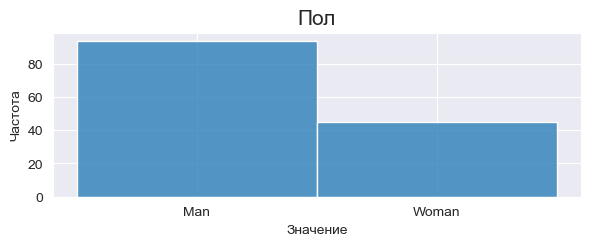

In [25]:
#Параметры для построения графиков
list_param = ['gender']
#Наименования параметров для построения графиков
list_name_param = ['Пол']
#Заголовок листа
suptitle = ''
#Построение графиков
hist_graph (df_face,list_param,list_name_param,suptitle)

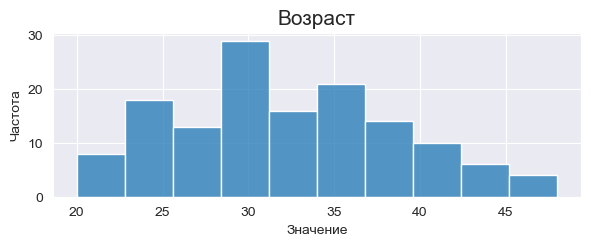

In [26]:
#Параметры для построения графиков
list_param = ['age']
#Наименования параметров для построения графиков
list_name_param = ['Возраст']
#Заголовок листа
suptitle = ''
#Построение графиков
hist_graph (df_face,list_param,list_name_param,suptitle)

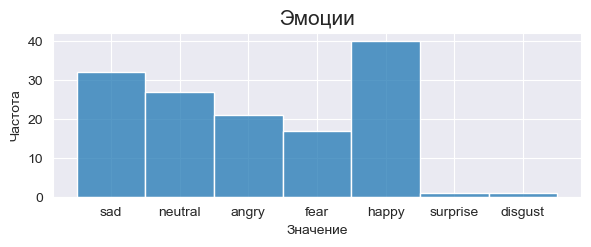

In [27]:
#Параметры для построения графиков
list_param = ['emotion']
#Наименования параметров для построения графиков
list_name_param = ['Эмоции']
#Заголовок листа
suptitle = ''
#Построение графиков
hist_graph (df_face,list_param,list_name_param,suptitle)

## Собираем контекстную информацию о группе

In [29]:
# Для обработки текста
nltk.download('stopwords')

russian_stopwords = set(stopwords.words("russian"))

# 2. Настройки
POSTS_LIMIT = 100

# 3. Подключение к VK API
vk_session = vk_api.VkApi(token=TOKEN)
vk = vk_session.get_api()

print("✅ Подключение к VK API установлено.")

✅ Подключение к VK API установлено.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Doctor_PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Скачивание последних постов со стены группы

In [30]:
group_posts = []

for group_name, group_id in GROUPS.items():
    print(f"\n📥 Скачиваем посты из группы: {group_name}")
    try:
        response = vk.wall.get(owner_id=group_id, count=POSTS_LIMIT)
        posts = response['items']
        print(f"✅ Загружено {len(posts)} постов.")
        
        for post in posts:
            post["group"] = group_name  # добавляем имя группы
            group_posts.append(post)

    except Exception as e:
        print(f"⚠️ Ошибка при скачивании постов для {group_name}: {e}")


📥 Скачиваем посты из группы: westra_tk
✅ Загружено 100 постов.

📥 Скачиваем посты из группы: runcomrun
✅ Загружено 100 постов.

📥 Скачиваем посты из группы: geekpicnic
✅ Загружено 100 постов.


In [41]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Doctor_PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Doctor_PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
import re
import gensim
import gensim.corpora as corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

texts_clean = []

for post in group_posts:
    text = post.get("text", "").lower()
    text = re.sub(r"http\S+|www\S+|[^а-яa-z\s]", " ", text)
    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 3]
    texts_clean.append(words)

texts_clean = [text for text in texts_clean if len(text) > 0]

# Строим словарь и корпус
id2word = corpora.Dictionary(texts_clean)
corpus = [id2word.doc2bow(text) for text in texts_clean]

# Обучаем LDA модель
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20,         # Кол-во тем — можно изменить
    random_state=42,
    passes=10,
    per_word_topics=True
)

# 📝 Вывод тем
for idx, topic in lda_model.print_topics(num_words=8):
    print(f"\n Тема {idx + 1}:")
    print(topic)


 Тема 1:
0.006*"видео" + 0.005*"сергеевна" + 0.005*"туризма" + 0.004*"фильм" + 0.004*"апреля" + 0.004*"ориентирование" + 0.004*"александр" + 0.004*"иван"

 Тема 2:
0.007*"кластер" + 0.006*"сергей" + 0.006*"михаил" + 0.006*"александр" + 0.004*"результаты" + 0.004*"андрей" + 0.004*"пары" + 0.004*"титков"

 Тема 3:
0.007*"runcomrun" + 0.007*"московскийполумарафон" + 0.006*"полумарафона" + 0.006*"московского" + 0.005*"маршрут" + 0.005*"дистанции" + 0.005*"будут" + 0.004*"участников"

 Тема 4:
0.009*"picnic" + 0.009*"geek" + 0.007*"фестиваля" + 0.006*"баскаков" + 0.006*"мечты" + 0.006*"технологий" + 0.006*"александр" + 0.006*"сергеевич"

 Тема 5:
0.008*"группа" + 0.004*"нами" + 0.004*"день" + 0.004*"также" + 0.004*"ногами" + 0.003*"поход" + 0.003*"geek" + 0.003*"горный"

 Тема 6:
0.007*"runcomrun" + 0.006*"технологий" + 0.005*"время" + 0.005*"партн" + 0.005*"geek" + 0.005*"picnic" + 0.004*"апрель" + 0.004*"engine"

 Тема 7:
0.004*"лисья" + 0.004*"гора" + 0.003*"апреля" + 0.003*"группе" + 0

## Связь тематики с товарными категориями

### Cловарь тем → товарных категорий

In [46]:
# Создаем словарь товарных категорий
theme_to_category = {
    "спорт": "Спортивная одежда, спортивные товары",
    "путешествия": "Туристическое снаряжение, одежда для туризма",
    "туризм": "Туристическое снаряжение, туристические услуги",
    "электроника": "Гаджеты, умные часы, наушники",
    "фитнес": "Фитнес-клубы, спортивное питание",
    "мотоциклы": "Экипировка для мотоциклистов, мотоаксессуары",
    "авто": "Автоаксессуары, шины, масла",
    "еда": "Продукты, доставка еды",
    "здоровье": "Витамины, аптечные товары",
    "развлечения": "Билеты на концерты, мероприятия",
    "отдых": "Путёвки, отдых на природе"
}

# Готовим функцию для классификации тематики поста
def detect_theme(text):
    themes_found = []
    text = text.lower()

    for theme_keyword in theme_to_category.keys():
        if theme_keyword in text:
            themes_found.append(theme_keyword)

    return themes_found

### Обрабатка постов

In [47]:
# Обрабатываем посты: определяем темы
posts_data = []

for post in posts:
    text = post.get("text", "").lower()

    if not text.strip():
        continue

    themes = detect_theme(text)

    if themes:
        for theme in themes:
            posts_data.append({
                "post_id": post["id"],
                "theme_detected": theme,
                "category_recommendation": theme_to_category[theme],
                "post_text_snippet": text[:100]  # кусочек текста
            })

# Сохраняем результат в CSV

recommendations_df = pd.DataFrame(posts_data)

output_csv = "analysis_recommendations.csv"
recommendations_df.to_csv(output_csv, index=False, encoding="utf-8")

print(f"✅ Сохранено {len(recommendations_df)} рекомендаций в файл {output_csv}")
display(recommendations_df.head(10))

✅ Сохранено 16 рекомендаций в файл analysis_recommendations.csv


,post_id,theme_detected,category_recommendation,post_text_snippet
0,46312,спорт,"Спортивная одежда, спортивные товары","результаты конкурса runit 🏃🏻‍♂️🏃🏻‍♂️🏃🏻‍♂️\n\nмы готовы объявить победителя, который получит билет на м"
1,46172,авто,"Автоаксессуары, шины, масла",молодёжный центр союза кинематографистов россии проводит показ собственных короткометражных фильмов
2,46172,отдых,"Путёвки, отдых на природе",молодёжный центр союза кинематографистов россии проводит показ собственных короткометражных фильмов
3,46117,спорт,"Спортивная одежда, спортивные товары",наш спортивный партнёр фестиваля науки и технологий geek picnic – [club96937874|fitmost] 🏃🏻‍♂️\n\nеди
4,46117,фитнес,"Фитнес-клубы, спортивное питание",наш спортивный партнёр фестиваля науки и технологий geek picnic – [club96937874|fitmost] 🏃🏻‍♂️\n\nеди
5,46033,спорт,"Спортивная одежда, спортивные товары",кем ты можешь стать в газпром цпс?🧙\n\nраспределительная шляпа со встроенной нейросетью даст ответ!\n\nп
6,46009,авто,"Автоаксессуары, шины, масла",институт бизнеса и дизайна [club639014|b&d] примет участие в нашем фестивале науки и технологий geek
7,46001,авто,"Автоаксессуары, шины, масла",розыгрыш от острова мечты и geek picnic 😍\n\n📷 хотите получить еще больше положительных эмоций от geek
8,46001,отдых,"Путёвки, отдых на природе",розыгрыш от острова мечты и geek picnic 😍\n\n📷 хотите получить еще больше положительных эмоций от geek
9,45849,авто,"Автоаксессуары, шины, масла",совместно с федеральной сетью книжных [club22142529|читай-город] и институтом бизнеса и дизайна [clu


### Анализ тем

In [48]:
# Группируем и считаем количество вхождений каждой темы

theme_counts = recommendations_df['theme_detected'].value_counts().reset_index()
theme_counts.columns = ["theme", "count"]

print("📈 Популярность тем в группе:")
display(theme_counts)

📈 Популярность тем в группе:


,theme,count
0,спорт,6
1,авто,6
2,отдых,2
3,фитнес,2


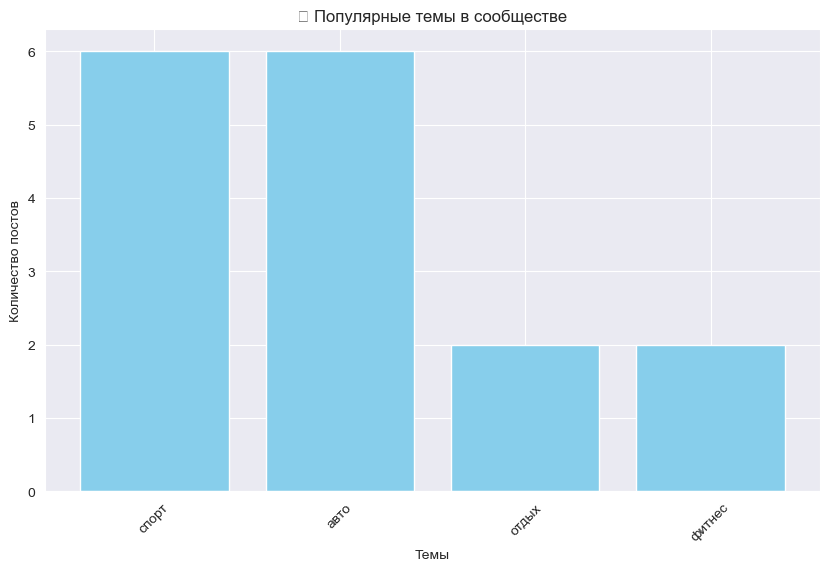

In [49]:
# Визуализируем популярность тем
plt.figure(figsize=(10, 6))
plt.bar(theme_counts['theme'], theme_counts['count'], color='skyblue')
plt.xticks(rotation=45)
plt.title("📊 Популярные темы в сообществе")
plt.xlabel("Темы")
plt.ylabel("Количество постов")
plt.grid(True)
plt.show()

In [50]:
# Находим Топ-3 самых популярных тем

top_3_themes = theme_counts.head(3)

print("🏆 Топ-3 самых популярных тем:")
for idx, row in top_3_themes.iterrows():
    print(f"{idx+1}. {row['theme']} — {row['count']} постов")

print("\n📋 Рекомендация для рекламы:")
print("- Сфокусировать рекламу на этих темах.")
print("- Предложить товары/услуги по этим направлениям.")

🏆 Топ-3 самых популярных тем:
1. спорт — 6 постов
2. авто — 6 постов
3. отдых — 2 постов

📋 Рекомендация для рекламы:
- Сфокусировать рекламу на этих темах.
- Предложить товары/услуги по этим направлениям.


## Анализ живой аудитории.
Что делаем?   
1.	Получаем число подписчиков через VK API (groups.getById)   
2.	Собираем лайки и комментарии для каждого поста (wall.get)   
3.	Считаем среднюю активность (средние лайки/комменты на пост)   
4.	Вычисляем реальный Engagement Rate    
5.	Сравниваем с данными по мероприятиям (число лиц на фото) ищем закономерности.   

In [27]:
# Получаем информацию о группе
group_info = vk.groups.getById(group_id=abs(GROUPS[GROUP_NAME]), fields="members_count")
members_count = group_info[0]["members_count"]

print(f" Количество подписчиков в группе {GROUP_NAME}: {members_count}")

 Количество подписчиков в группе geekpicnic: 55630


In [28]:
# 📌 Добавляем информацию о лайках и комментариях
posts_likes_comments = []

for post in posts:
    try:
        post_id = post['id']
        likes_count = post['likes']['count']
        comments_count = post['comments']['count']
        views_count = post['views']['count'] if 'views' in post else 0  # <- вот здесь

        posts_likes_comments.append({
            "post_id": post_id,
            "likes": likes_count,
            "comments": comments_count,
            "views": views_count  # сохраняем!
        })
    except KeyError:
        continue  # если каких-то полей нет

# 📌 Превращаем в датафрейм
engagement_df = pd.DataFrame(posts_likes_comments)

# 📌 Средние лайки и комментарии
average_likes = engagement_df['likes'].mean()
average_comments = engagement_df['comments'].mean()
average_views = engagement_df['views'].mean()

print(f"❤️ Среднее количество лайков на пост: {average_likes:.2f}")
print(f"💬 Среднее количество комментариев на пост: {average_comments:.2f}")
print(f"💬 Среднее количество просмотров на пост: {average_views:.2f}")

engagement_df = pd.DataFrame(posts_likes_comments)
display(engagement_df.head(10))

❤️ Среднее количество лайков на пост: 19.24
💬 Среднее количество комментариев на пост: 3.87
💬 Среднее количество просмотров на пост: 3653.69


,post_id,likes,comments,views
0,46389,33,3,8696
1,46356,18,5,8102
2,46355,12,0,6961
3,46354,10,0,5895
4,46353,10,0,4804
5,46352,6,0,4153
6,46351,6,0,3777
7,46350,5,0,3153
8,46349,4,0,2802
9,46348,7,0,2624


In [29]:
# Вычисляем Engagement Rate
convers_rate = ((average_likes + average_comments) / average_views) * 100

print(f"📊 Конверсия группы: {convers_rate:.2f}%")

📊 Конверсия группы: 0.63%


In [30]:
# Уникальные лица на мероприятии (предположим, уже посчитано ранее)
unique_faces_count = len(embeddings_info)  # embeddings_info — это наши уникальные лица

print(f" Число уникальных лиц на мероприятии: {unique_faces_count}")

# Доля активных участников
active_share = (unique_faces_count / average_views) * 100

print(f" Доля участников мероприятий от пассивных просмотров: {active_share:.2f}%")

 Число уникальных лиц на мероприятии: 305
 Доля участников мероприятий от пассивных просмотров: 8.35%


## Вывод

#### Итоговый вывод проекта VK Visual Insights  
(на примере анализа группы Geek Picnic)

---

##### Зачем это нужно

С развитием социальных сетей наблюдается перенасыщение и "деградация" аудитории:

- Люди подписаны на группы, но не участвуют в их жизни.
- Присутствует большое количество ботов и "мертвых" аккаунтов.
- Многие активные участники мероприятий не имеют аккаунта или не подписаны на группу.
- После мероприятий происходит отписка или отсутствие подписки.

Единственный реальный способ оценки живой аудитории — это анализ фотографий с мероприятий с помощью нейросетей.

---

#####  Что делает VK Visual Insights

- Анализирует фото мероприятий через компьютерное зрение.
- Определяет реальное число активных участников (уникальные лица).
- Строит демографические профили: пол, возраст, эмоции.
- Помогает рекомендовать товары и услуги на основе интересов аудитории.
- Сравнивает данные активности в группе с активностью на мероприятиях.

---

#####  Основные результаты анализа Geek Picnic

#####  Гендерный состав:

- Мужчины: 64.4%
- Женщины: 35.6%

#####  Возрастная структура:

- 18–29 лет: 41.1%
- 30–44 года: 54.8%
- 45–59 лет: 4.1%
- Младше 18 и старше 60: 0%

Вывод: аудитория — взрослые, активные молодые люди и специалисты.

---

#####  Эмоциональный фон:

- Радость (happy): 28.8%
- Нейтральные эмоции (neutral): 25.3%
- Грусть (sad): 24.0%
- Страх (fear): 13.7%
- Агрессия, удивление, отвращение — минимальны.

Вывод: контент вызывает в основном положительные и нейтральные эмоции, благоприятная эмоциональная среда для рекламы.

---

#####  Тематика интересов:

На основании текстового анализа постов выявлены топ-темы:

| Тема    | Постов |
|---------|--------|
| Спорт   | 6      |
| Авто    | 6      |
| Отдых   | 2      |
| Фитнес  | 2      |

Вывод: основные интересы аудитории — активный образ жизни, спорт, авто и технологии.

---

#####  Рекомендации для рекламы:

- Ориентироваться на категории: спортивные товары, электроника, товары для отдыха и автоаксессуары.
- Делать упор на позитивную, активную жизненную позицию в рекламных креативах.
- Предлагать товары и мероприятия, поддерживающие активный отдых.

---

#####  Живая активность в группе

| Показатель                  | Значение |
|-------------------------------|----------|
| Среднее лайков на пост        | 19.24    |
| Среднее комментариев на пост  | 3.87     |
| Среднее просмотров на пост    | 3653.69  |
| Конверсия (ER) группы         | 0.63%    |
| Число уникальных лиц на мероприятии | 305 |
| Доля участников мероприятий от просмотров | 8.35% |

---

#####  Выводы по активности:

- Engagement Rate ниже среднего уровня (обычно хороший ER > 1–2%), аудитория пассивная в онлайне.
- Однако реальная вовлечённость через участие в мероприятиях высокая: 8.35% от просмотров проявили офлайн-активность.

То есть, хотя пользователи редко лайкают и комментируют посты, они активно участвуют в реальных событиях.

---

#####  Общий вывод

VK Visual Insights позволяет выявить реальную активную аудиторию, её возраст, эмоциональный фон, интересы и поведенческие особенности.

Это даёт маркетологам, организаторам мероприятий и брендам возможность:

- Работать с реальными клиентами, а не с "мертвыми душами".
- Таргетировать рекламу точнее.
- Повышать эффективность продвижения товаров и услуг.

---

#####  Файлы отчёта:

- `analysis_results.csv`
- `generated_ads.csv`
- `embeddings_info.pkl`


